[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1zxFEbSElK2Z72HVPUfBxop80l1zX3lJT?usp=sharing)

Submission by: Chiara Vega

# Crop Yield Estimation

## Problem Statement

Humanity continues to grapple with numerous challenges concerning hunger, primarily driven by food supply issues. One of the key hurdles is the growing global population, which places immense pressure on the already strained food systems.  Addressing these multifaceted challenges demands collective efforts, innovative approaches, and sustainable agricultural practices to ensure food security for all.

## Task 1 (50 points)

You are tasked to build a computer vision system that will process drone images showing the health of the crops and predict the yield. This will help the farmers to understand the state of their crops and plan the next steps accordingly. As a data scientist, you are required to build a machine learning model and after a litarature survey you have decided to use an approach similar to the one [described in this paper](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5426829/).

Luckily you are also able to locate some helper code in [this repository](https://github.com/GoogleCloudPlatform/practical-ml-vision-book/blob/master/11_adv_problems/11a_counting.ipynb).

### Task 1A (20 points)

Replicate the results of the code in the repository ensuring that you train the model with a much larger number of images, epochs and other parameters of your choice to present the best possible performance.

### Task 1B (30 points)

Unfortunately some of the berries are bad - they have a `black` color and it is interspersed amongst the good berriers. Produce images where the bad berries are 0% to 100 % of the total berries. For each image you sample uniformly random between 0 and 100 to determine the percentage of bad berries. You need to implement a system that separates bad crops - an image is `bad` when black berries exceed > 50% of the total berries per image.

Describe your approach on the modeling strategy on how to achieve that, implement the method and obtain results that manifest the performance of your predictor.

# Task 1

In [ ]:
# Confirm connection to GPU with tensorflow
import tensorflow as tf
print(tf.version.VERSION)
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

2.12.0
Found GPU at: /device:GPU:0


In [ ]:
# import necessary libraries
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
import scipy.ndimage as ndimage
from skimage import draw

60 berries simulated


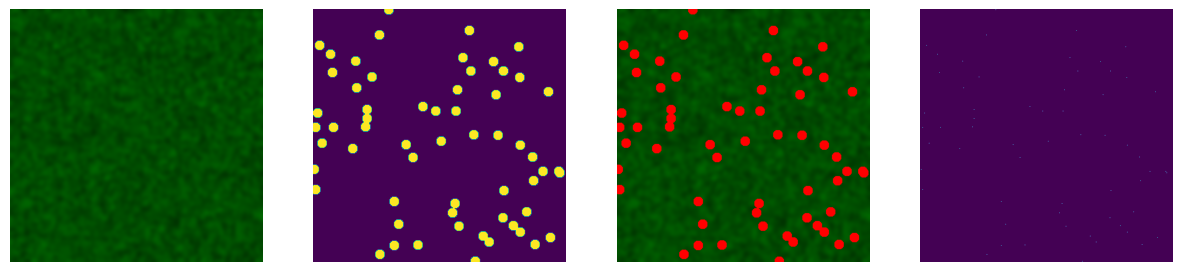

In [ ]:
# set image and patch sizes
FULL_IMG_WIDTH = 512
FULL_IMG_HEIGHT = 512
IMG_CHANNELS = 3
PATCH_WIDTH = 32
PATCH_HEIGHT = 32
INPUT_WIDTH = PATCH_WIDTH*2
INPUT_HEIGHT = PATCH_HEIGHT*2

# generate images with a random background and randomly placed "berries"
def generate_image(with_intermediates=False):
  # the image has a random greenish background that is smoothed
  backgr = np.zeros([FULL_IMG_HEIGHT, FULL_IMG_WIDTH, IMG_CHANNELS])
  backgr[ np.random.rand(FULL_IMG_HEIGHT, FULL_IMG_WIDTH) < 0.3, 1 ] = 1
  backgr = ndimage.gaussian_filter(backgr, sigma=(5, 5, 0), order=0)

  # between 25 and 75 berries randomly placed
  num_berries = np.random.randint(25, 75)
  berry_cx = np.random.randint(0, FULL_IMG_WIDTH, size=num_berries)
  berry_cy = np.random.randint(0, FULL_IMG_HEIGHT, size=num_berries)
  label = np.zeros([FULL_IMG_WIDTH, FULL_IMG_HEIGHT])
  label[berry_cx, berry_cy] = 1

  # draw the berries which are 10 px in radius
  berries = np.zeros([FULL_IMG_HEIGHT, FULL_IMG_WIDTH])
  for idx in range(len(berry_cx)):
    rr, cc = draw.disk((berry_cx[idx], berry_cy[idx]),
                         radius=10,
                         shape=berries.shape)
    berries[rr, cc] = 1

  # add berries to the background
  img = np.copy(backgr)
  img[berries > 0] = [1, 0, 0] # red

  if with_intermediates:
    print("{} berries simulated".format(num_berries))
    return backgr, berries, img, label
  else:
    return img, label

# visualize generated images
images = generate_image(True)
f, ax = plt.subplots(1, len(images), figsize=(15, 5))
for idx, img in enumerate(images):
  ax[idx].imshow(img)
  ax[idx].axis('off')

In [ ]:
## given an image, get the patches
def get_patches(img, label, verbose=False):
  img = tf.expand_dims(img, axis=0)
  label = tf.expand_dims(tf.expand_dims(label, axis=0), axis=-1)
  if verbose:
    print(img.shape, label.shape)
  num_patches = (FULL_IMG_HEIGHT // PATCH_HEIGHT)**2
  patches = tf.image.extract_patches(img,
                                     sizes=[1, INPUT_HEIGHT, INPUT_WIDTH, 1],
                                     strides=[1, PATCH_HEIGHT, PATCH_WIDTH, 1],
                                     rates=[1, 1, 1, 1],
                                     padding='SAME',
                                     name='get_patches')
  patches = tf.reshape(patches, [num_patches, -1])
  labels = tf.image.extract_patches(label,
                                    sizes=[1, PATCH_HEIGHT, PATCH_WIDTH, 1],
                                    strides=[1, PATCH_HEIGHT, PATCH_WIDTH, 1],
                                    rates=[1, 1, 1, 1],
                                    padding='VALID',
                                    name='get_labels')
  labels = tf.reshape(labels, [num_patches, -1])
  # the "density" is the number of points in the label patch
  patch_labels = tf.math.reduce_sum(labels, axis=[1], name='calc_density')
  if verbose:
    print(patches.shape, labels.shape, patch_labels.shape)
  return patches, patch_labels

In [ ]:
# Getting input data
def create_dataset(num_full_images):
  def generate_patches():
    for i in range(num_full_images):
      img, label = generate_image()
      patches, patch_labels = get_patches(img, label)
      # print(len(patches) * num_full_images)
      for patch, patch_label in zip(patches, patch_labels):
        yield patch, patch_label

  return tf.data.Dataset.from_generator(
    generate_patches,
    (tf.float32, tf.float32), # patch, patch_label
    (tf.TensorShape([INPUT_HEIGHT*INPUT_WIDTH*IMG_CHANNELS]),
    tf.TensorShape([]))
  )

# print patches' informations
trainds = create_dataset(1) # will create 256 patches per image
for img, label in trainds.take(3):
  avg = tf.math.reduce_mean(img) # avg pixel in image
  print(img.shape, label.numpy(), avg.numpy())

(12288,) 0.0 0.054946035
(12288,) 0.0 0.073464505
(12288,) 0.0 0.09037739


## Task 1A

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 64, 64, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 64)        3

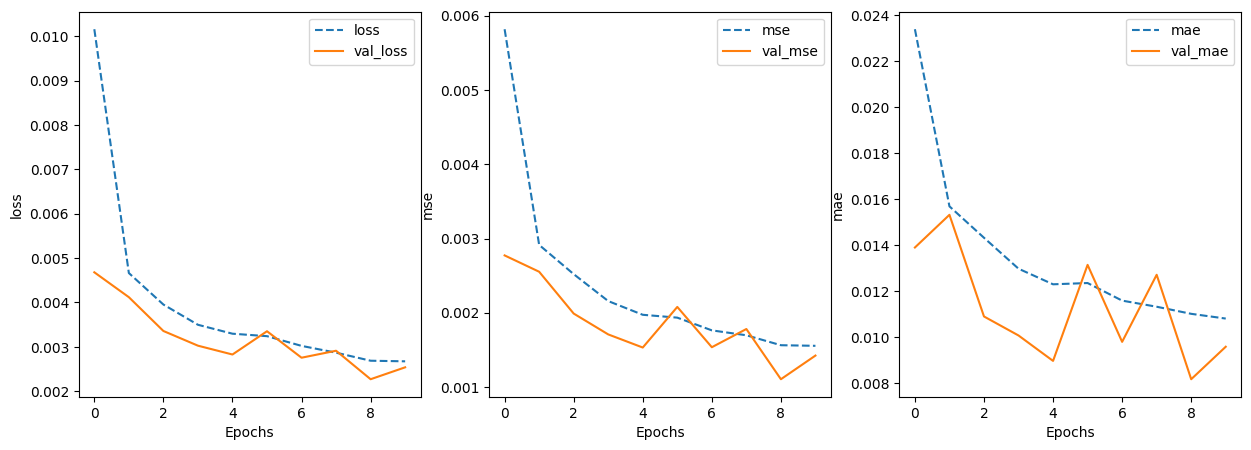

In [ ]:
# Train
NUM_TRAIN = 1000 # changed from 200 to 1000
NUM_EVAL = 100 # changed from 10 to 100
NUM_EPOCHS = 10 # changed from 5 to 10

# define function to plot the metrics
def training_plot(metrics, history):
  f, ax = plt.subplots(1, len(metrics), figsize=(5*len(metrics), 5))
  for idx, metric in enumerate(metrics):
    ax[idx].plot(history.history[metric], ls='dashed')
    ax[idx].set_xlabel("Epochs")
    ax[idx].set_ylabel(metric)
    ax[idx].plot(history.history['val_' + metric]);
    ax[idx].legend([metric, 'val_' + metric])

# define function for training and evaluating the model
def train_and_evaluate(batch_size = 32,
                       lrate = 0.001, # default in Adam constructor
                       l1 = 1e-5, # changed from 0 to 1e-5
                       l2 = 1e-4, # changed from 0 to 1e-4
                       num_filters = 32):
  regularizer = tf.keras.regularizers.l1_l2(l1, l2)
  train_dataset = create_dataset(NUM_TRAIN).batch(batch_size)
  eval_dataset = create_dataset(NUM_EVAL).batch(64)

  # a simple convnet. you can make it more complex, of course
  # the patch is flattened, so we start by reshaping to an image
  model = tf.keras.Sequential([
              tf.keras.layers.Reshape([INPUT_HEIGHT, INPUT_WIDTH, IMG_CHANNELS],
                                      input_shape=[INPUT_WIDTH * INPUT_HEIGHT * IMG_CHANNELS]),
              tf.keras.layers.Conv2D(num_filters, (3,3), activation='relu'),
              tf.keras.layers.MaxPooling2D((2, 2)),
              tf.keras.layers.Conv2D(num_filters*2, (3,3), activation='relu'),
              tf.keras.layers.MaxPooling2D((2, 2)),
              tf.keras.layers.Conv2D(num_filters*2, (3,3), activation='relu'),
              tf.keras.layers.Flatten(),
              tf.keras.layers.Dense(num_filters*2,
                                    kernel_regularizer=regularizer,
                                    activation=tf.keras.activations.relu),
              tf.keras.layers.Dense(1, activation='linear')
  ])
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lrate),
                  loss=tf.keras.losses.mean_squared_error,
                  metrics=['mse', 'mae'])
  print(model.summary())
  history = model.fit(train_dataset, validation_data=eval_dataset, epochs=NUM_EPOCHS)
  training_plot(['loss', 'mse', 'mae'], history)
  return model

model = train_and_evaluate()

66 berries simulated
8/8 [==============================] - 0s 3ms/step
35 berries simulated
8/8 [==============================] - 0s 3ms/step
54 berries simulated
8/8 [==============================] - 0s 3ms/step
51 berries simulated
8/8 [==============================] - 0s 3ms/step
36 berries simulated
8/8 [==============================] - 0s 3ms/step
28 berries simulated
8/8 [==============================] - 0s 3ms/step
40 berries simulated
8/8 [==============================] - 0s 3ms/step
41 berries simulated
8/8 [==============================] - 0s 3ms/step
66 berries simulated
8/8 [==============================] - 0s 3ms/step
48 berries simulated
8/8 [==============================] - 0s 3ms/step
71 berries simulated
8/8 [==============================] - 0s 3ms/step
74 berries simulated
8/8 [==============================] - 0s 3ms/step
28 berries simulated
8/8 [==============================] - 0s 3ms/step
36 berries simulated
8/8 [==============================] - 0s 3

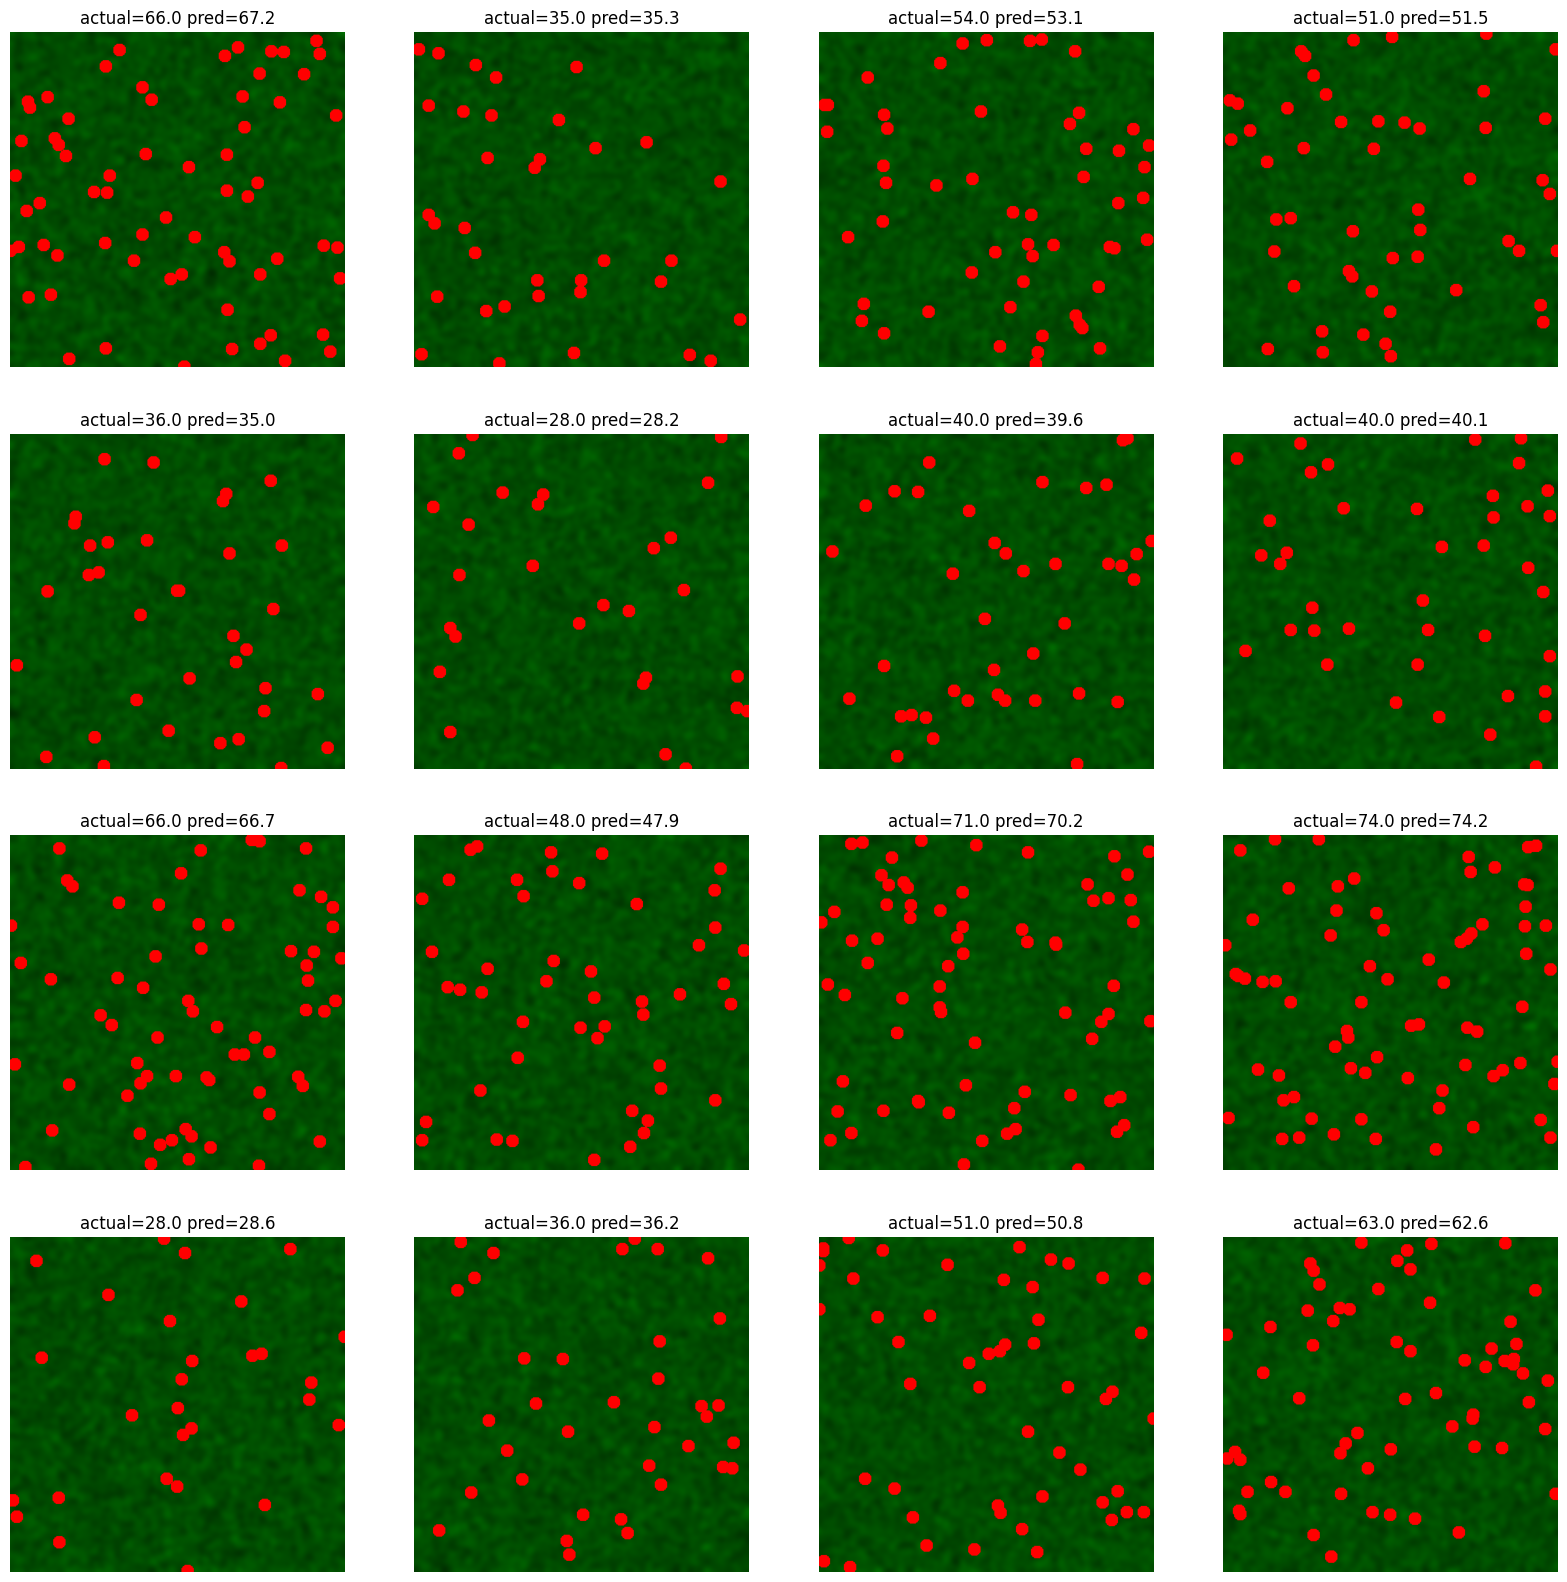

In [ ]:
## prediction.
def count_berries(model, img):
  num_patches = (FULL_IMG_HEIGHT // PATCH_HEIGHT)**2
  img = tf.expand_dims(img, axis=0)
  patches = tf.image.extract_patches(img,
                sizes=[1, INPUT_HEIGHT, INPUT_WIDTH, 1],
                strides=[1, PATCH_HEIGHT, PATCH_WIDTH, 1],
                rates=[1, 1, 1, 1],
                padding='SAME',
                name='get_patches')
  patches = tf.reshape(patches, [num_patches, -1])
  densities = model.predict(patches)
  return tf.reduce_sum(densities)

# use an example image
f, ax = plt.subplots(4, 4, figsize=(20, 20))
for idx in range(16):
  backgr, berries, img, label = generate_image(True)
  ax[idx//4, idx%4].imshow(img)
  ax[idx//4, idx%4].set_title("actual={:.1f} pred={:.1f}".format(
    tf.reduce_sum(label).numpy(),
    count_berries(model, img).numpy()
  ))
  ax[idx//4, idx%4].axis('off')

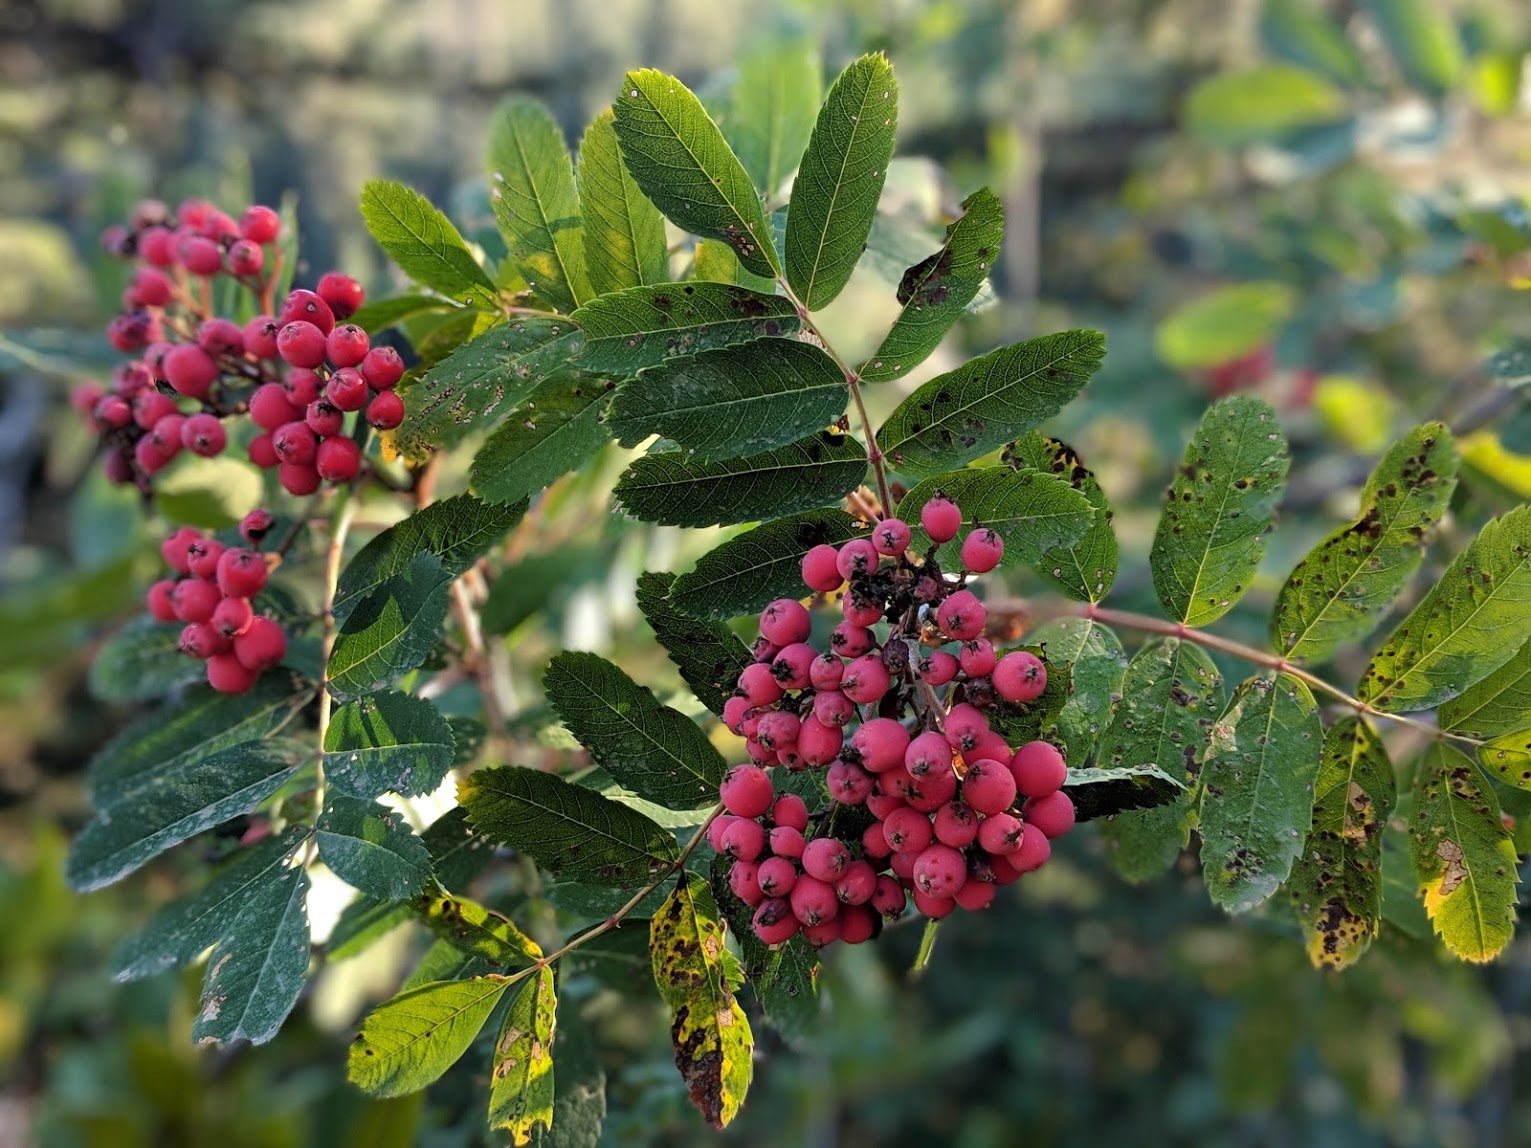

In [ ]:
# display berries.jpg info
!file berries.jpg

berries.jpg: JPEG image data, JFIF standard 1.01, aspect ratio, density 72x72, segment length 16, Exif Standard: [TIFF image data, big-endian, direntries=2, orientation=upper-left], baseline, precision 8, 1531x1148, components 3


In [ ]:
# print count of berries
contents = tf.io.read_file('./berries.jpg')
img = tf.image.decode_image(contents)
img = tf.image.resize(img, [FULL_IMG_WIDTH, FULL_IMG_HEIGHT])
n = count_berries(model, img)
print(n.numpy())

8/8 [==============================] - 0s 5ms/step
325.7717


The real number is around 300. Result 325.7717 appears decent.

## Task 1B

74 berries simulated (88% bad)


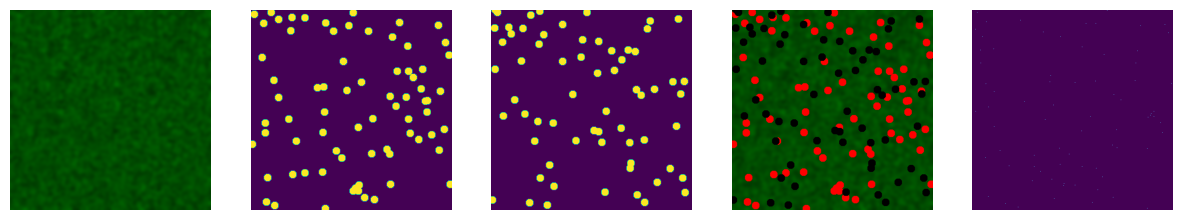

In [ ]:
# generate images with a random background and randomly placed "berries" and "bad berries"
def generate_image(with_intermediates=False):
  # the image has a random greenish background that is smoothed
  backgr = np.zeros([FULL_IMG_HEIGHT, FULL_IMG_WIDTH, IMG_CHANNELS])
  backgr[np.random.rand(FULL_IMG_HEIGHT, FULL_IMG_WIDTH) < 0.3, 1] = 1
  backgr = ndimage.gaussian_filter(backgr, sigma=(5, 5, 0), order=0)

  # between 25 and 75 berries randomly placed
  num_berries = np.random.randint(25, 75)
  berry_cx = np.random.randint(0, FULL_IMG_WIDTH, size=num_berries)
  berry_cy = np.random.randint(0, FULL_IMG_HEIGHT, size=num_berries)
  label = np.zeros([FULL_IMG_HEIGHT, FULL_IMG_WIDTH])
  label[berry_cx, berry_cy] = 1

  # draw the good berries (red)
  berries = np.zeros([FULL_IMG_HEIGHT, FULL_IMG_WIDTH])
  for idx in range(len(berry_cx)):
    rr, cc = draw.disk((berry_cy[idx], berry_cx[idx]), radius=10, shape=berries.shape)
    berries[rr, cc] = 1

  # introduce bad berries
  bad_percentage = np.random.randint(0, 101)  # Random percentage of bad berries
  num_bad_berries = int(num_berries * bad_percentage / 100)
  bad_berry_cx = np.random.randint(0, FULL_IMG_WIDTH, size=num_bad_berries)
  bad_berry_cy = np.random.randint(0, FULL_IMG_HEIGHT, size=num_bad_berries)

  # draw the bad berries (black)
  bad_berries = np.zeros([FULL_IMG_HEIGHT, FULL_IMG_WIDTH])
  for idx in range(len(bad_berry_cx)):
    rr, cc = draw.disk((bad_berry_cy[idx], bad_berry_cx[idx]), radius=10, shape=bad_berries.shape)
    bad_berries[rr, cc] = 1

  # combine good and bad berries
  img = np.copy(backgr)
  img[berries > 0] = [1, 0, 0]  # red
  img[bad_berries > 0] = [0, 0, 0]  # black

  if with_intermediates:
    print("{} berries simulated ({}% bad)".format(num_berries, bad_percentage))
    return backgr, berries, bad_berries, img, label
  else:
    return img, label

# visualize generated images
images = generate_image(True)
f, ax = plt.subplots(1, len(images), figsize=(15, 5))
for idx, img in enumerate(images):
    ax[idx].imshow(img)
    ax[idx].axis('off')

In [ ]:
# generate patches and labels for the modified image
def get_patches(img, label, verbose=False):
  img = tf.expand_dims(img, axis=0)
  label = tf.expand_dims(tf.expand_dims(label, axis=0), axis=-1)
  if verbose:
    print(img.shape, label.shape)
  num_patches = (FULL_IMG_HEIGHT // PATCH_HEIGHT)**2
  patches = tf.image.extract_patches(img,
                                     sizes=[1, INPUT_HEIGHT, INPUT_WIDTH, 1],
                                     strides=[1, PATCH_HEIGHT, PATCH_WIDTH, 1],
                                     rates=[1, 1, 1, 1],
                                     padding='SAME',
                                     name='get_patches')
  patches = tf.reshape(patches, [num_patches, -1])
  labels = tf.image.extract_patches(label,
                                    sizes=[1, PATCH_HEIGHT, PATCH_WIDTH, 1],
                                    strides=[1, PATCH_HEIGHT, PATCH_WIDTH, 1],
                                    rates=[1, 1, 1, 1],
                                    padding='SAME',  # Modified to 'SAME' to include bad berries
                                    name='get_labels')
  labels = tf.reshape(labels, [num_patches, -1])
  # the "density" is the number of points in the label patch
  patch_labels = tf.math.reduce_sum(labels, axis=[1], name='calc_density')
  if verbose:
    print(patches.shape, labels.shape, patch_labels.shape)
  return patches, patch_labels

In [ ]:
# create the dataset of patches and labels for the modified image
def create_dataset(num_full_images):
  def generate_patches():
    for i in range(num_full_images):
      img, label = generate_image()
      patches, patch_labels = get_patches(img, label)
      for patch, patch_label in zip(patches, patch_labels):
        yield patch, patch_label

  return tf.data.Dataset.from_generator(
    generate_patches,
    (tf.float32, tf.float32), # patch, patch_label
    (tf.TensorShape([INPUT_HEIGHT*INPUT_WIDTH*IMG_CHANNELS]),
    tf.TensorShape([]))
  )

trainds = create_dataset(1) # will create patches per image
for img, label in trainds.take(3):
  avg = tf.math.reduce_mean(img) # avg pixel in patch
  print(img.shape, label.numpy(), avg.numpy())

(12288,) 1.0 0.07635555
(12288,) 0.0 0.082489654
(12288,) 0.0 0.07215655


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_5 (Reshape)         (None, 64, 64, 3)         0         
                                                                 
 conv2d_15 (Conv2D)          (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 31, 31, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 14, 14, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 12, 12, 64)       

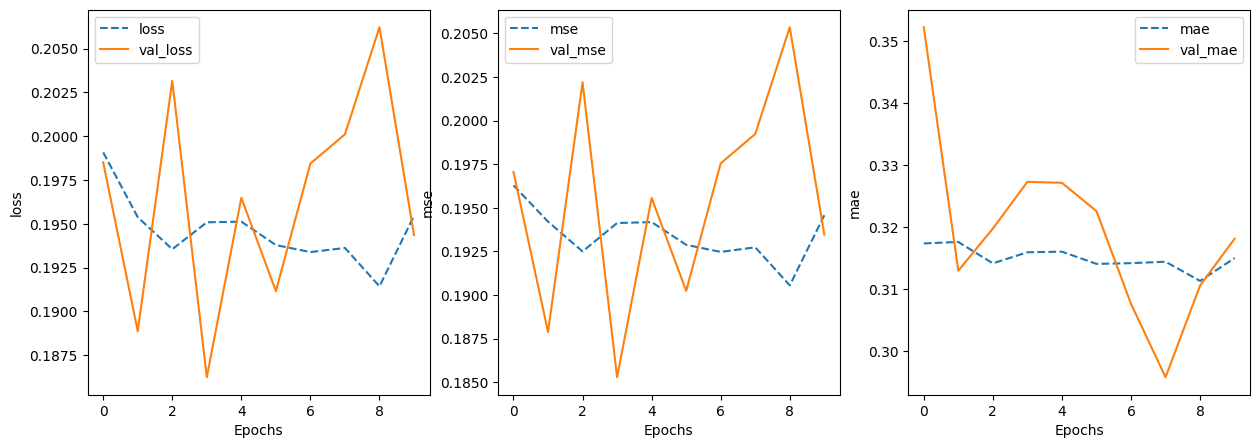

In [ ]:
# Train
NUM_TRAIN = 1000 # changed from 200 to 1000
NUM_EVAL = 100 # changed from 10 to 100
NUM_EPOCHS = 10 # changed from 5 to 10

# define function to plot the metrics
def training_plot(metrics, history):
  f, ax = plt.subplots(1, len(metrics), figsize=(5*len(metrics), 5))
  for idx, metric in enumerate(metrics):
    ax[idx].plot(history.history[metric], ls='dashed')
    ax[idx].set_xlabel("Epochs")
    ax[idx].set_ylabel(metric)
    ax[idx].plot(history.history['val_' + metric]);
    ax[idx].legend([metric, 'val_' + metric])

# define function for training and evaluating the model
def train_and_evaluate(batch_size = 32,
                       lrate = 0.001, # default in Adam constructor
                       l1 = 1e-5, # changed from 0 to 1e-5
                       l2 = 1e-4, # changed from 0 to 1e-4
                       num_filters = 32):
  regularizer = tf.keras.regularizers.l1_l2(l1, l2)
  train_dataset = create_dataset(NUM_TRAIN).batch(batch_size)
  eval_dataset = create_dataset(NUM_EVAL).batch(64)

  # a simple convnet. you can make it more complex, of course
  # the patch is flattened, so we start by reshaping to an image
  model = tf.keras.Sequential([
              tf.keras.layers.Reshape([INPUT_HEIGHT, INPUT_WIDTH, IMG_CHANNELS],
                                      input_shape=[INPUT_WIDTH * INPUT_HEIGHT * IMG_CHANNELS]),
              tf.keras.layers.Conv2D(num_filters, (3,3), activation='relu'),
              tf.keras.layers.MaxPooling2D((2, 2)),
              tf.keras.layers.Conv2D(num_filters*2, (3,3), activation='relu'),
              tf.keras.layers.MaxPooling2D((2, 2)),
              tf.keras.layers.Conv2D(num_filters*2, (3,3), activation='relu'),
              tf.keras.layers.Flatten(),
              tf.keras.layers.Dense(num_filters*2,
                                    kernel_regularizer=regularizer,
                                    activation=tf.keras.activations.relu),
              tf.keras.layers.Dense(1, activation='linear')
  ])
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lrate),
                  loss=tf.keras.losses.mean_squared_error,
                  metrics=['mse', 'mae'])
  print(model.summary())
  history = model.fit(train_dataset, validation_data=eval_dataset, epochs=NUM_EPOCHS)
  training_plot(['loss', 'mse', 'mae'], history)
  return model

model = train_and_evaluate()

29 berries simulated (90% bad)
8/8 [==============================] - 0s 4ms/step
72 berries simulated (79% bad)
8/8 [==============================] - 0s 4ms/step
44 berries simulated (57% bad)
8/8 [==============================] - 0s 3ms/step
74 berries simulated (53% bad)
8/8 [==============================] - 0s 3ms/step
66 berries simulated (65% bad)
8/8 [==============================] - 0s 4ms/step
74 berries simulated (73% bad)
8/8 [==============================] - 0s 3ms/step
58 berries simulated (9% bad)
8/8 [==============================] - 0s 3ms/step
42 berries simulated (55% bad)
8/8 [==============================] - 0s 3ms/step
54 berries simulated (35% bad)
8/8 [==============================] - 0s 5ms/step
48 berries simulated (74% bad)
8/8 [==============================] - 0s 4ms/step
32 berries simulated (54% bad)
8/8 [==============================] - 0s 4ms/step
42 berries simulated (82% bad)
8/8 [==============================] - 0s 3ms/step
38 berries simula

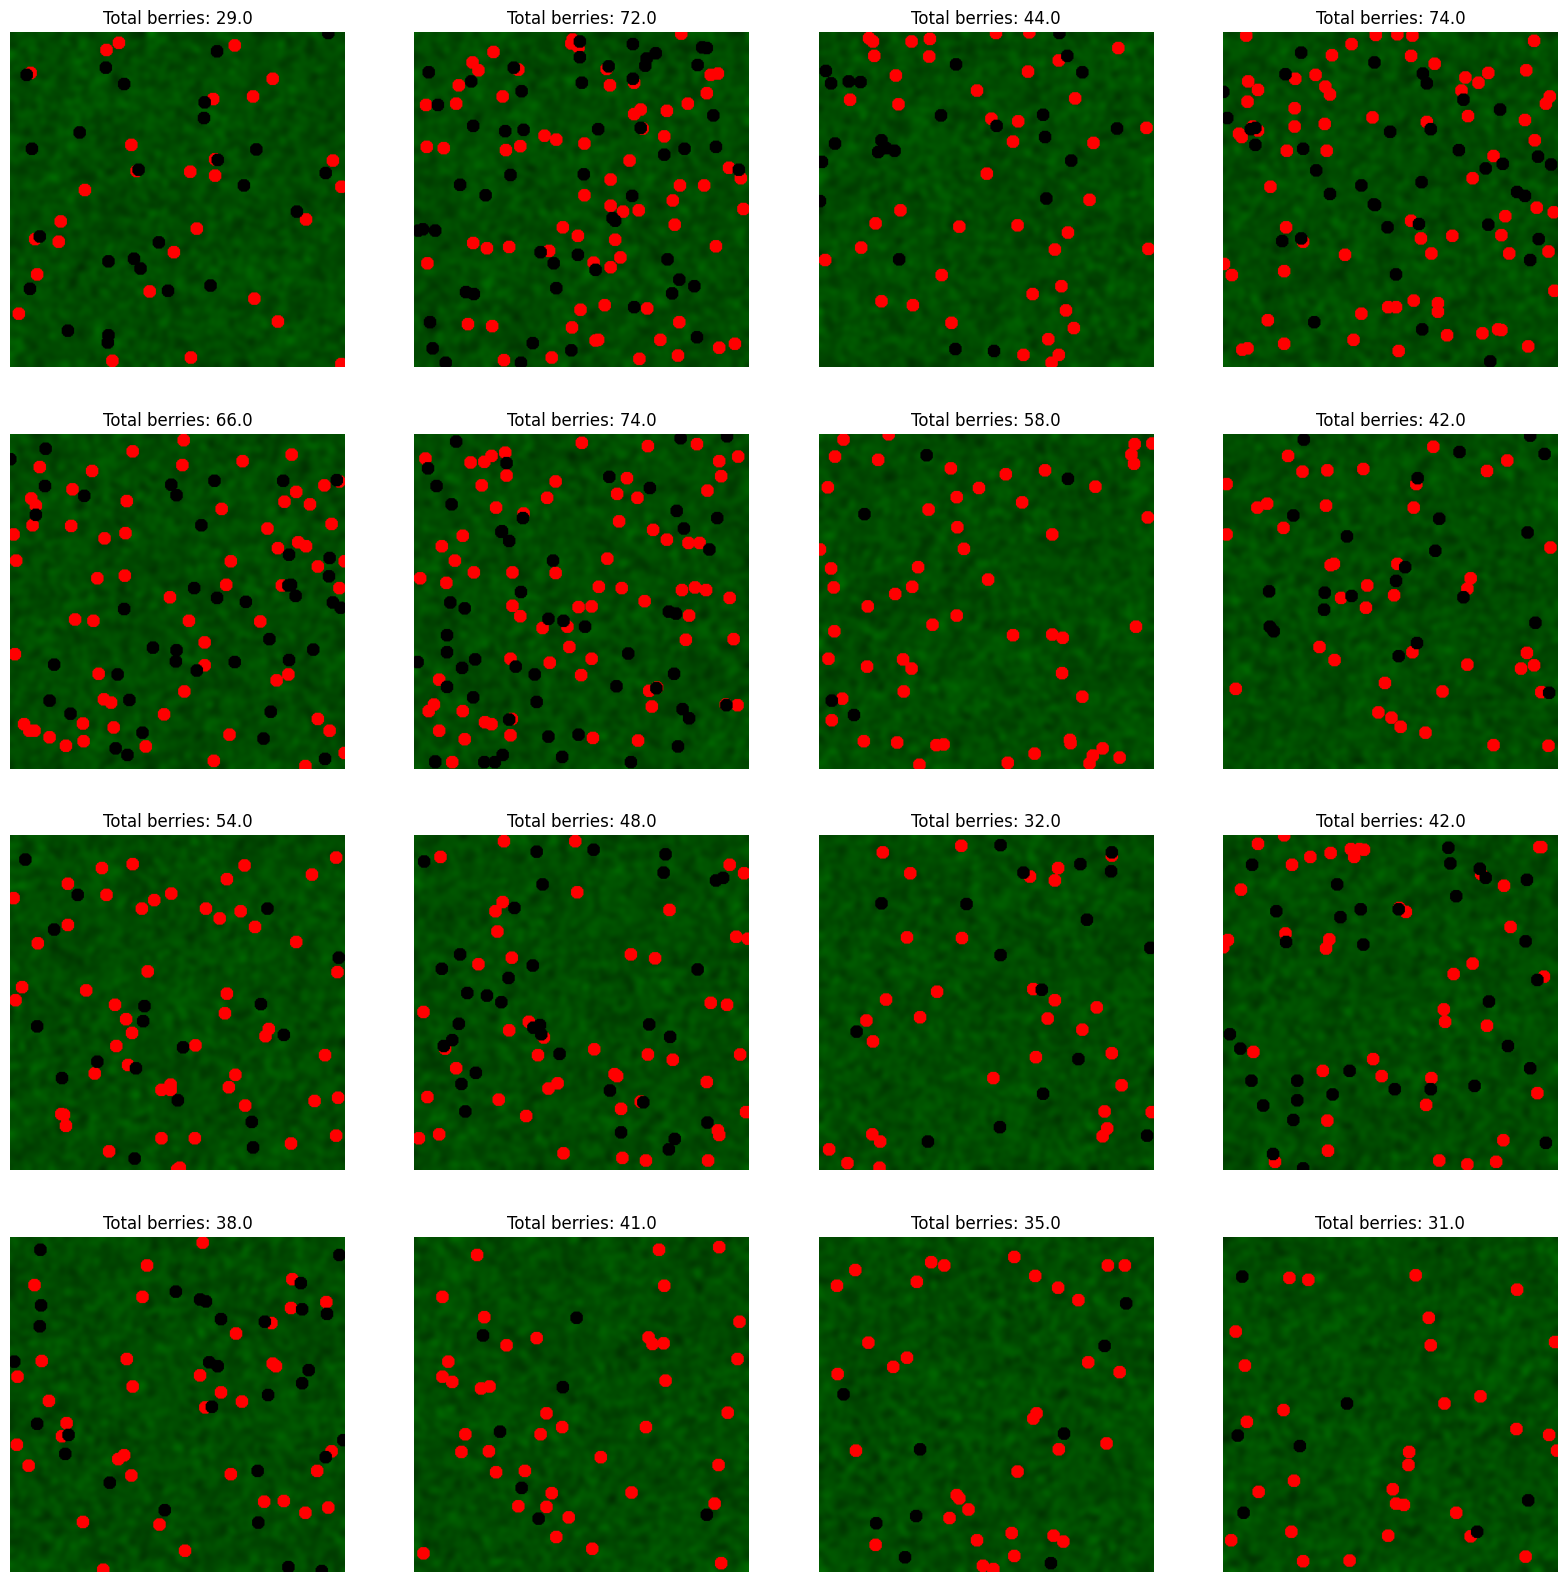

In [ ]:
# count the total number of berries
# and calculate the percentage of bad berries for example images
def count_berries(model, img):
    num_patches = (FULL_IMG_HEIGHT // PATCH_HEIGHT) ** 2
    img = tf.expand_dims(img, axis=0)
    patches = tf.image.extract_patches(img,
                                       sizes=[1, INPUT_HEIGHT, INPUT_WIDTH, 1],
                                       strides=[1, PATCH_HEIGHT, PATCH_WIDTH, 1],
                                       rates=[1, 1, 1, 1],
                                       padding='SAME',
                                       name='get_patches')
    patches = tf.reshape(patches, [num_patches, -1])
    densities = model.predict(patches)

    total_berries = tf.reduce_sum(densities)
    bad_berries = tf.reduce_sum(tf.where(densities < 0.5, 1.0, 0.0))
    bad_percentage = (bad_berries / total_berries) * 100

    if bad_percentage > 50.0:
        return bad_percentage
    else:
        return total_berries

# visualizing example images and their berry count for the modified image
f, ax = plt.subplots(4, 4, figsize=(20, 20))
for idx in range(16):
    backgr, berries, bad_berries, img, label = generate_image(True)
    crop_type = count_berries(model, img)
    ax[idx // 4, idx % 4].imshow(img)
    ax[idx // 4, idx % 4].set_title(f"Total berries: {tf.reduce_sum(label).numpy()}")
    ax[idx // 4, idx % 4].axis('off')

plt.show()

In [ ]:
# print berry count or percentage of bad berries
contents = tf.io.read_file('./berries.jpg')
img = tf.image.decode_image(contents)
img = tf.image.resize(img, [FULL_IMG_WIDTH, FULL_IMG_HEIGHT])
n = count_berries(model, img)
print(n.numpy())

8/8 [==============================] - 0s 3ms/step
1058.4822
